In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

In [19]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [21]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):

    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

In [33]:
datasets = ['Dataset/imagery']

class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [35]:
def load_data():
    images, labels = [], []
    
    for dataset in datasets:
        
        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(dataset,folder,file)
                
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (48,48))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass
    
    return (images, labels)
    pass

In [37]:
(images, labels) = load_data()
images.shape, labels.shape

100%|██████████| 1000/1000 [00:04<00:00, 246.71it/s]


((4000, 48, 48, 3), (4000,))

In [39]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,3000
ship,1000


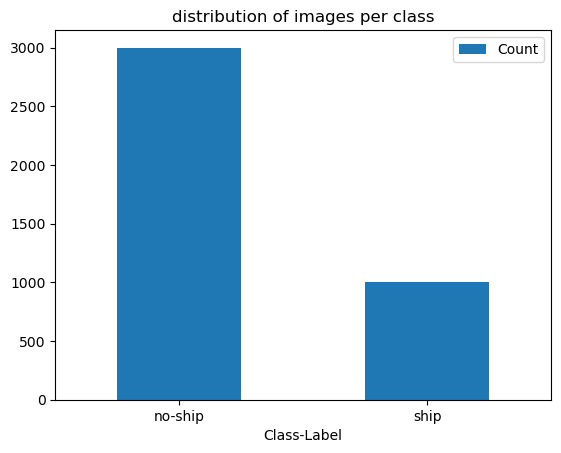

In [41]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

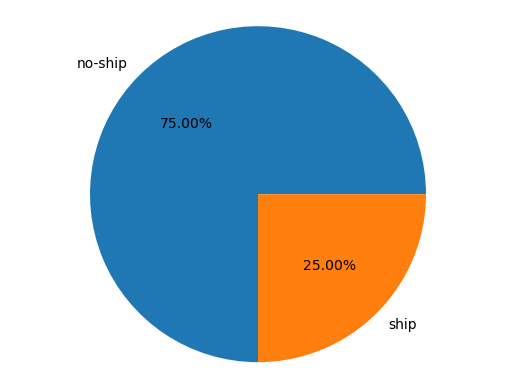

In [43]:
plt.pie(count,explode=(0,0),
       labels = class_names,
       autopct = "%1.2f%%")
plt.axis('equal');

In [45]:
AUGMENTATION = True

In [47]:
def augment_add(images, seq, labels):
    
    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):
        
        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass
    
    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)
    
    return (augmented_images, augmented_labels)
    pass

In [49]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

In [51]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

4000it [00:04, 987.88it/s]  


In [55]:
images.shape, labels.shape

((6000, 48, 48, 3), (6000,))

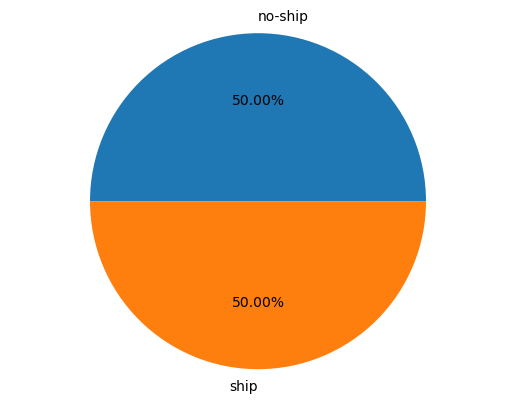

In [57]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');

In [59]:
labels = to_categorical(labels)

In [63]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

In [65]:
total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((4200, 48, 48, 3), (1200, 48, 48, 3), (600, 48, 48, 3))

In [69]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

Explanation of features
Conv2D - This is a 2 dimensional convolutional layer, the number of filters decide what the convolutional layer learns. Greater the number of filters, greater the amount of information obtained.

MaxPooling2D - This reduces the spatial dimensions of the feature map produced by the convolutional layer without losing any range information. This allows a model to become slightly more robust

Dropout - This removes a user-defined percentage of links between neurons of consecutive layers. This allows the model to be robust. It can be used in both fully convolutional layers and fully connected layers.

BatchNormalization - This layer normalises the values present in the hidden part of the neural network. This is similar to MinMax/Standard scaling applied in machine learning algorithms

Padding- This pads the feature map/input image with zeros allowing border features to stay.


In [80]:
def conv_block(X, k, filters, stage, block, s=2):
    conv_base_name = 'conv_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + "_branch"
    
    F1 = filters

    X = Conv2D(filters=F1, kernel_size=(k, k), strides=(s, s),
               padding='same', name=conv_base_name + '2a')(X)
    X = BatchNormalization(name=bn_base_name + '2a')(X)
    X = Activation('relu')(X)
    
    return X


In [82]:
def basic_model(input_shape,classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((5,5))(X_input)
    
    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)

    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(128)(X)
    X = Activation("relu")(X)
    
    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)
    
    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')
    
    return model
    pass

In [84]:
model = basic_model(input_shape=(48,48,3),classes=2)

In [134]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='basic_model.png', show_shapes=True, show_layer_names=True)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [138]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=1e-3)


In [140]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

In [147]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [155]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

In [157]:
epochs = 50
batch_size = 16

history = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1, 
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs]
#                    class_weight=classWeight # Uncomment if AUGMENTATION is set to FALSE
                   )

Epoch 1/50
248/262 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7376 - loss: 0.5205

D:\anaconda\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.75500, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.7426 - loss: 0.5121 - val_accuracy: 0.7550 - val_loss: 0.4827
Epoch 2/50
247/262 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9098 - loss: 0.2353
Epoch 2: val_accuracy improved from 0.75500 to 0.94917, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9106 - loss: 0.2334 - val_accuracy: 0.9492 - val_loss: 0.1320
Epoch 3/50
248/262 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9474 - loss: 0.1505
Epoch 3: val_accuracy improved from 0.94917 to 0.97083, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9474 - loss: 0.1500 - val_accuracy: 0.9708 - val_loss: 0.0826
Epoch 4/50
246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9539 - loss: 0.1286
Epoch 4: val_accuracy did not improve from 0.97083
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9540 - loss: 0.1284 - val_accuracy: 0.9442 - val_loss: 0.1402
Epoch 5/50
246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9643 - loss: 0.0957
Epoch 5: val_accuracy improved from 0.97083 to 0.97583, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9644 - loss: 0.0953 - val_accuracy: 0.9758 - val_loss: 0.0638
Epoch 6/50
247/262 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9676 - loss: 0.0869
Epoch 6: val_accuracy did not improve from 0.97583
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9678 - loss: 0.0866 - val_accuracy: 0.9458 - val_loss: 0.2058
Epoch 7/50
248/262 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9752 - loss: 0.0749
Epoch 7: val_accuracy improved from 0.97583 to 0.98250, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9750 - loss: 0.0753 - val_accuracy: 0.9825 - val_loss: 0.0541
Epoch 8/50
246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9733 - loss: 0.0716
Epoch 8: val_accuracy improved from 0.98250 to 0.98500, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9735 - loss: 0.0713 - val_accuracy: 0.9850 - val_loss: 0.0443
Epoch 9/50
245/262 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9600 - loss: 0.1223
Epoch 9: val_accuracy did not improve from 0.98500
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9605 - loss: 0.1206 - val_accuracy: 0.9783 - val_loss: 0.0552
Epoch 10/50
247/262 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9867 - loss: 0.0463
Epoch 10: val_accuracy improved from 0.98500 to 0.98583, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9866 - loss: 0.0466 - val_accuracy: 0.9858 - val_loss: 0.0427
Epoch 11/50
248/262 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9789 - loss: 0.0668
Epoch 11: val_accuracy did not improve from 0.98583
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9788 - loss: 0.0665 - val_accuracy: 0.9675 - val_loss: 0.0982
Epoch 12/50
246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9802 - loss: 0.0550
Epoch 12: val_accuracy improved from 0.98583 to 0.99000, saving model to model_weights.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9803 - loss: 0.0549 - val_accuracy: 0.9900 - val_loss: 0.0267
Epoch 13/50
247/262 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9858 - loss: 0.0412
Epoch 13: val_accuracy did not improve from 0.99000
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9857 - loss: 0.0416 - val_accuracy: 0.9850 - val_loss: 0.0409
Epoch 14/50
246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9831 - loss: 0.0396
Epoch 14: val_accuracy did not improve from 0.99000
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9833 - loss: 0.0396 - val_accuracy: 0.9758 - val_loss: 0.0582
Epoch 15/50
247/262 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9866 - loss: 0.0350
Epoch 15: val_accuracy did not improve from 0.99000
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9866 - loss: 0.0351 - val_accuracy: 0.9592 - val_loss: 0.1265
Epoch 16/50
247/262 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9820 - loss: 0.0565
Epoch 16: val_accura

262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9839 - loss: 0.0491 - val_accuracy: 0.9925 - val_loss: 0.0238
Epoch 19/50
247/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9914 - loss: 0.0244
Epoch 19: val_accuracy did not improve from 0.99250
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9914 - loss: 0.0247 - val_accuracy: 0.9842 - val_loss: 0.0522
Epoch 20/50
248/262 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9914 - loss: 0.0263
Epoch 20: val_accuracy did not improve from 0.99250
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9913 - loss: 0.0266 - val_accuracy: 0.9850 - val_loss: 0.0512
Epoch 21/50
248/262 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9900 - loss: 0.0242
Epoch 21: val_accuracy did not improve from 0.99250
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9902 - loss: 0.0241 - val_accuracy: 0.9842 - val_loss: 0.0521
Epoch 22/50
246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9892 - loss: 0.0327
Epoch 22: val_accura

262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9960 - loss: 0.0181 - val_accuracy: 0.9942 - val_loss: 0.0217
Epoch 37/50
247/262 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9939 - loss: 0.0141
Epoch 37: val_accuracy did not improve from 0.99417
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9938 - loss: 0.0142 - val_accuracy: 0.9900 - val_loss: 0.0350
Epoch 38/50
246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9919 - loss: 0.0174
Epoch 38: val_accuracy did not improve from 0.99417
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9921 - loss: 0.0174 - val_accuracy: 0.9925 - val_loss: 0.0264
Epoch 39/50
246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9921 - loss: 0.0211
Epoch 39: val_accuracy did not improve from 0.99417
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9920 - loss: 0.0212 - val_accuracy: 0.9892 - val_loss: 0.0364
Epoch 40/50
247/262 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9945 - loss: 0.0127
Epoch 40: val_accura

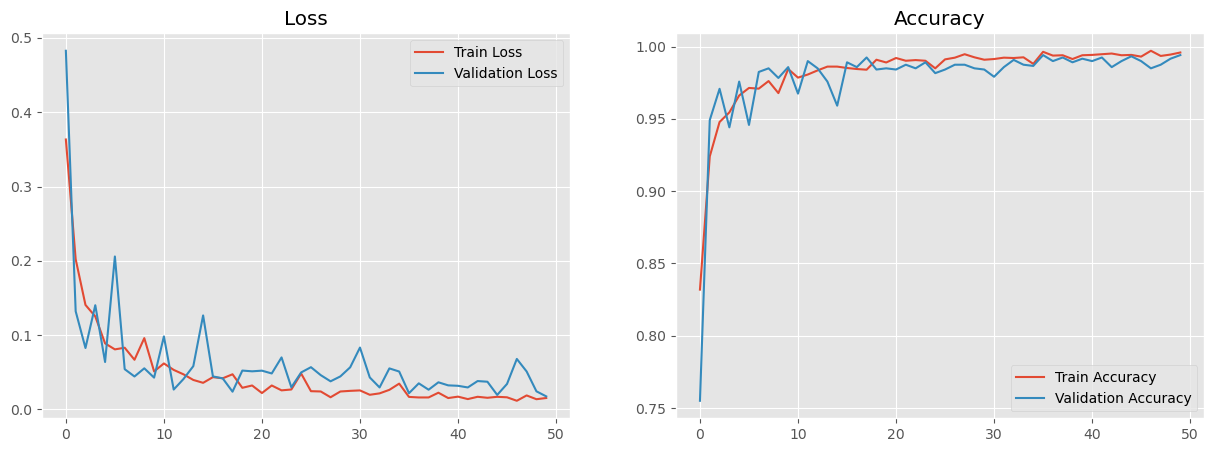

In [159]:
show_final_history(history)


In [161]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred,axis=1)
val_pred.shape

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


(1200,)

<Figure size 640x480 with 0 Axes>

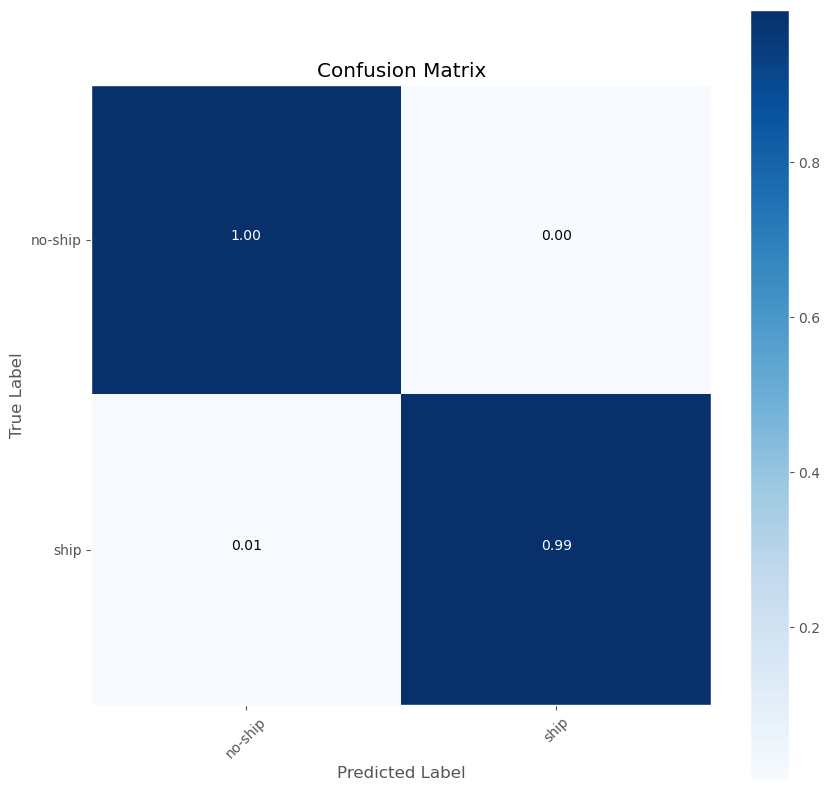

In [165]:
val_actual = np.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

In [175]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


(600,)

<Figure size 640x480 with 0 Axes>

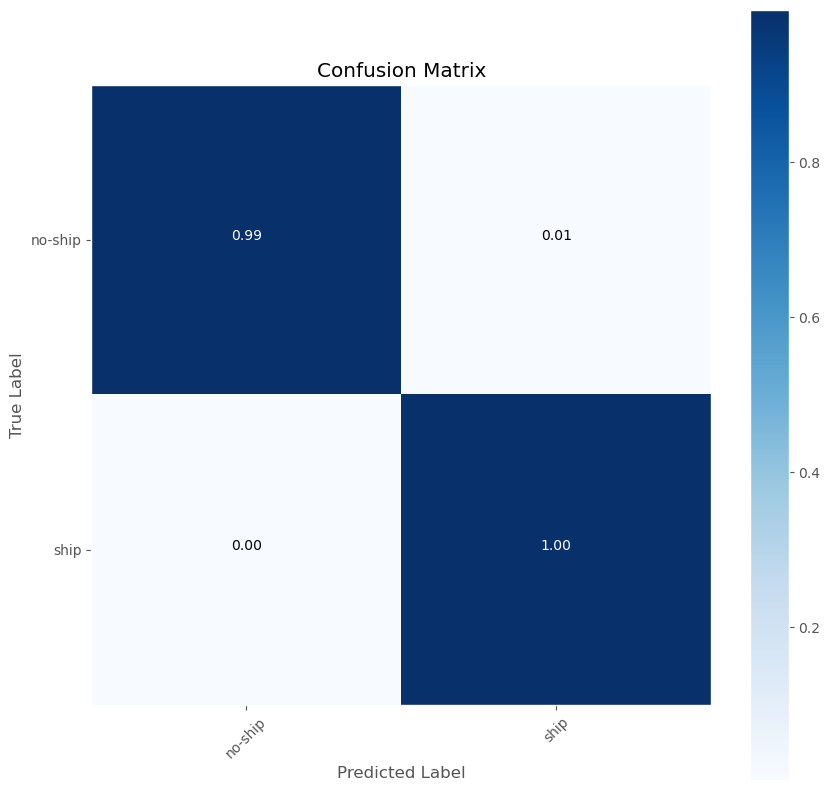

In [177]:
test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

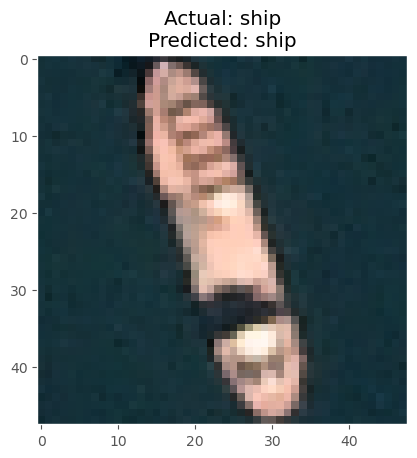

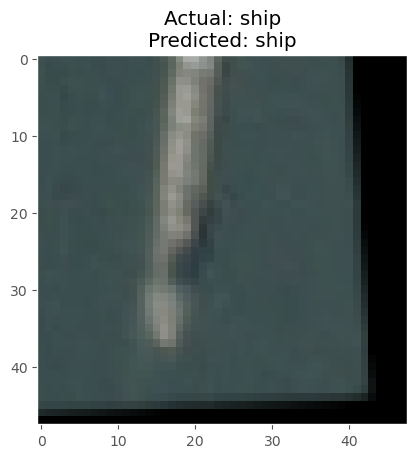

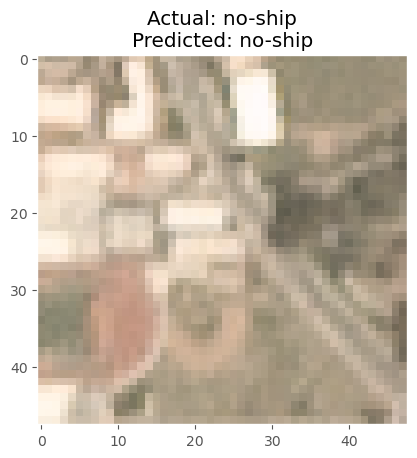

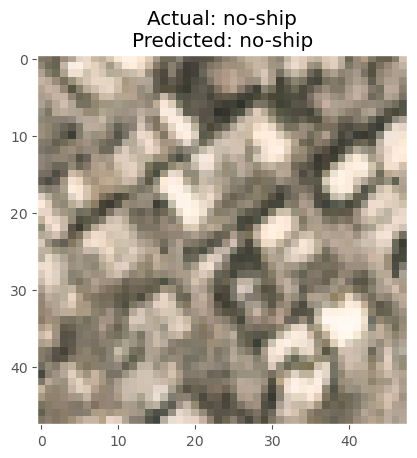

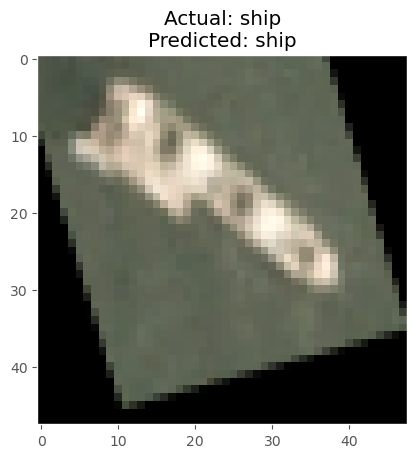

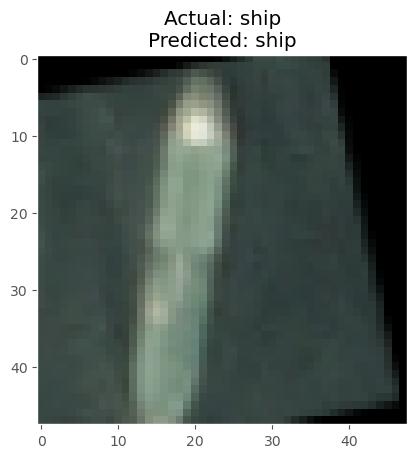

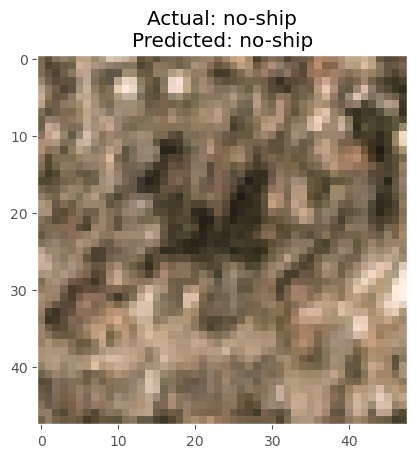

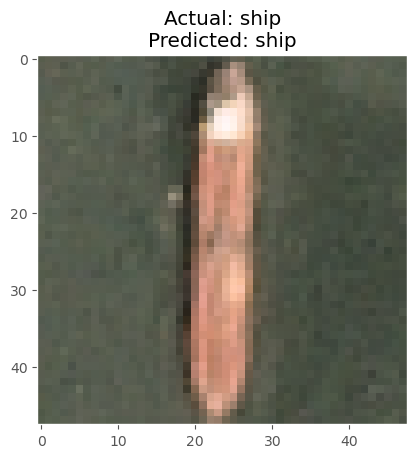

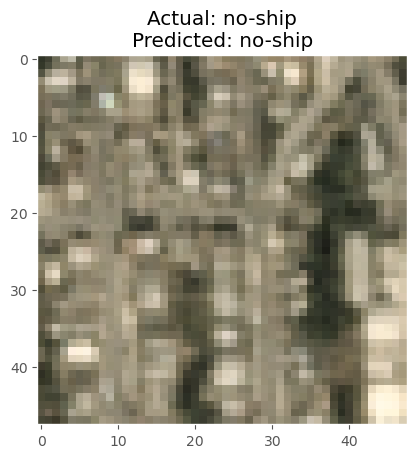

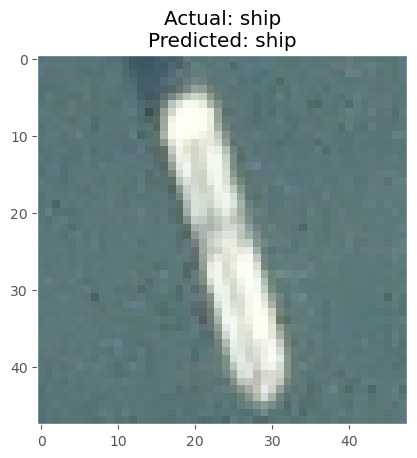

In [179]:
rnd_idx = random.sample(range(0,400),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels


for i,idx in enumerate(rnd_idx):
    
    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass

In [181]:
model.save("ship-model.h5")